In [1]:
# 在车杆环境上进行 Actor-Critic 算法的实验
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 首先定义策略网络PolicyNet，它的输入是状态，输出是动作的概率分布

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [3]:
# 定义 Actor-Critic 算法中的价值网络 ValueNet，其输入是某个状态，输出则是状态的价值估计

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [4]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device) # actor是策略网络
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # critic是价值网络
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)  # 策略网络优化器
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma  # 折扣因子，用于计算未来奖励的折现值
        self.device = device

    def take_action(self, state): # 根据当前状态选择动作
        state = torch.tensor([state], dtype=torch.float).to(self.device) 
        probs = self.actor(state)  # 策略网络，对输入状态进行前向传播，得到动作的概率分布
        action_dist = torch.distributions.Categorical(probs) # 构建一个多项分布，多项分布描述了一组离散型随机变量各出现的概率
        action = action_dist.sample()  # 从概率分布中采样得到动作
        return action.item()  # 返回采样动作

    def update(self, transition_dict): # 根据经验更新策略网络和价值网络
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # 在计算时序差分目标时，我们需要考虑终止状态的影响
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones) 
        # 时序差分误差
        td_delta = td_target - self.critic(states) 
        # 计算当前状态下，智能体选择每个动作的对数概率，并将其作为损失函数的一部分，用于更新策略网络的参数
        log_probs = torch.log(self.actor(states).gather(1, actions))
        # 计算策略网络的损失函数。detach()函数用于切断反向传播的梯度流，我们不希望在计算actor_loss时对td_delta张量进行反向传播，从而避免对critic网络的参数进行更新
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        # 计算价值网络的损失函数，即计算当前状态下的价值估计与时序差分目标的均方误差
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
        # 将策略网络和价值网络的梯度清零
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        # 更新策略网络和价值网络的参数
        actor_loss.backward()  
        critic_loss.backward()  
        self.actor_optimizer.step()  
        self.critic_optimizer.step()  

In [5]:
# 策略网络的学习率通常比值函数网络的学习率小，这是因为策略网络的更新通常比值函数网络的更新更加频繁，而且策略网络的更新通常比值函数网络的更新更加敏感
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/gym/envs/registration.py:592: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(s

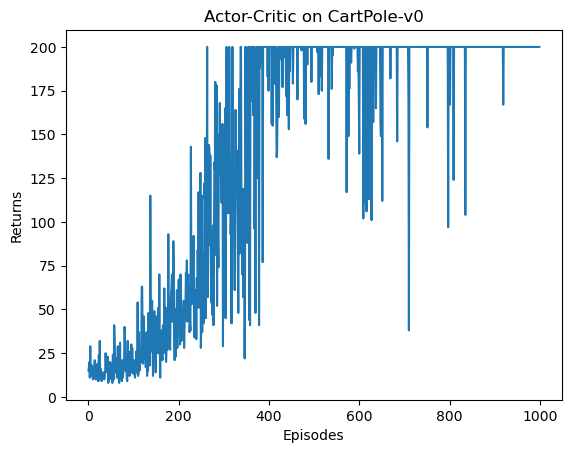

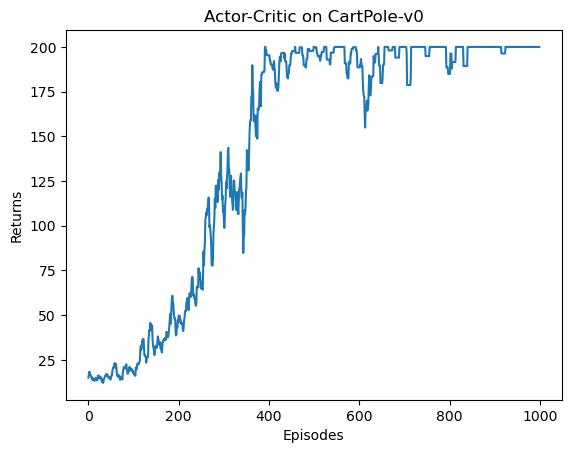

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()